#  <h1 style="text-align:center;">Assignment - 6</h1>

1. Print “Welcome to PDPU from process (processno_totalprocesses)".
2. Apply denoising algorithm to a set of n images with 4 processes. (n=4,8).
3. Analyze time taken by serial and openMPI processes.
4. Try for 100 or more number of images.

In [1]:
from mpi4py.futures import MPIPoolExecutor
from mpi4py import MPI
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [2]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

comm.Barrier()

for i in range(size):
    if rank == i:
        print('Welcome to PDPU From process %d of %d' % (rank, size))
    comm.Barrier()  

comm.Barrier()

Welcome to PDPU From process 0 of 1


In [4]:
!mpiexec -n 4 python mpi_script.py

Welcome to PDPU From processes 3 of 4
Welcome to PDPU From processes 1 of 4
Welcome to PDPU From processes 2 of 4
Welcome to PDPU From processes 0 of 4


In [5]:
!mpiexec -n 8 python mpi_script.py

Welcome to PDPU From processes 3 of 8
Welcome to PDPU From processes 7 of 8
Welcome to PDPU From processes 5 of 8
Welcome to PDPU From processes 1 of 8
Welcome to PDPU From processes 4 of 8
Welcome to PDPU From processes 2 of 8
Welcome to PDPU From processes 0 of 8
Welcome to PDPU From processes 6 of 8


In [9]:
def add_noise(image):
    noisy_image = image + np.random.normal(loc=0, scale=10, size=image.shape)
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def denoise(image):
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

def denoise_images(images, output_folder, rank=None):
    start_time = time.time()
    noisy_output_folder = os.path.join(output_folder, "noisy")
    denoised_output_folder = os.path.join(output_folder, "denoised")
    os.makedirs(noisy_output_folder, exist_ok=True)
    os.makedirs(denoised_output_folder, exist_ok=True)
    for i, image in enumerate(images):
        if image is None:
            print(f"Warning: Image {i} could not be loaded. Skipping.")
            continue
        noisy_image = add_noise(image)
        denoised_image = denoise(noisy_image)
        if rank is None or rank == 0:
            cv2.imwrite(os.path.join(noisy_output_folder, f"noisy_image_{i}.jpg"), noisy_image)
            cv2.imwrite(os.path.join(denoised_output_folder, f"denoised_image_{i}.jpg"), denoised_image)
    end_time = time.time()
    return end_time - start_time

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    folder_path = r"C:\Users\raval\jupyter_notebook\HPC_Lab\crick_data"
    output_folder = os.path.join(folder_path, "output1")
    image_files = os.listdir(folder_path)
    images = [cv2.imread(os.path.join(folder_path, file)) for file in image_files]

    if rank == 0:
        print(f"Number of images: {len(images)}")

    # Serial denoising
    if rank == 0:
        print("Serial Denoising:")
    comm.Barrier()  
    serial_time = denoise_images(images, output_folder, rank)
    if rank == 0:
        print(f"Time taken for serial denoising: {serial_time:.2f} seconds")

    # Parallel denoising
    if rank == 0:
        print("Parallel Denoising:")
    comm.Barrier()  
    num_images_per_process = len(images) // size
    start_index = rank * num_images_per_process
    end_index = start_index + num_images_per_process
    parallel_time = denoise_images(images[start_index:end_index], output_folder, rank)
    max_parallel_time = comm.reduce(parallel_time, op=MPI.MAX, root=0)
    if rank == 0:
        print(f"Time taken for parallel denoising: {max_parallel_time:.2f} seconds")

if __name__ == "__main__":
    main()

Number of images: 129
Serial Denoising:
Time taken for serial denoising: 65.78 seconds
Parallel Denoising:
Time taken for parallel denoising: 62.18 seconds


In [12]:
!mpiexec -n 4 python images_100.py

Number of images: 129
Serial Denoising:
Time taken for serial denoising: 78.91 seconds
Parallel Denoising:
Time taken for parallel denoising: 20.00 seconds


In [13]:
!mpiexec -n 8 python images_100.py

Number of images: 129
Serial Denoising:
Time taken for serial denoising: 104.83 seconds
Parallel Denoising:
Time taken for parallel denoising: 13.12 seconds


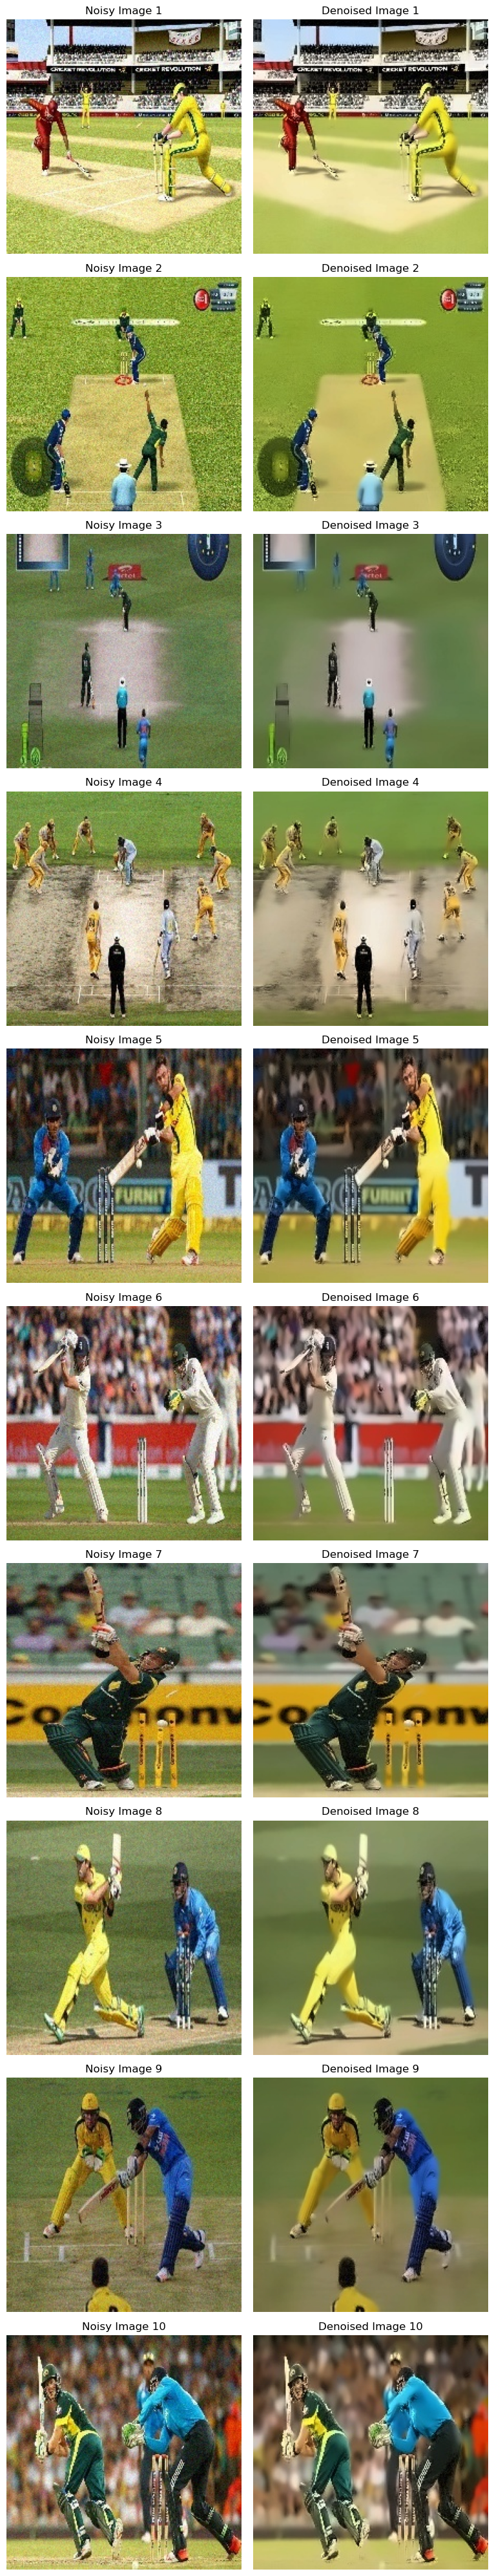

In [15]:
def plot_images_side_by_side(noisy_folder, denoised_folder):
    noisy_image_files = os.listdir(noisy_folder)
    denoised_image_files = os.listdir(denoised_folder)

    noisy_image_files.sort()
    denoised_image_files.sort()

    num_images = min(len(noisy_image_files), len(denoised_image_files), 10)
    fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 4))

    for i in range(num_images):
        noisy_image_path = os.path.join(noisy_folder, noisy_image_files[i])
        noisy_image = cv2.imread(noisy_image_path)
        noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)

        denoised_image_path = os.path.join(denoised_folder, denoised_image_files[i])
        denoised_image = cv2.imread(denoised_image_path)
        denoised_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB)

        axes[i, 0].imshow(noisy_image)
        axes[i, 0].set_title(f"Noisy Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(denoised_image)
        axes[i, 1].set_title(f"Denoised Image {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

noisy_folder = r"C:\Users\raval\jupyter_notebook\HPC_Lab\crick_data\output1\noisy"
denoised_folder = r"C:\Users\raval\jupyter_notebook\HPC_Lab\crick_data\output1\denoised"
plot_images_side_by_side(noisy_folder, denoised_folder)